In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datasets
import torch
from train import get_model_class
from style import plot_grads, plot_single_grad
from similarity_metrics import get_top_k, average_pairwise_score, top_k_sa, top_k_cdc, top_k_consistency
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [2]:
random_sources = ['rs', 'loo']

In [3]:
name = 'heloc'  # or 'german'
n_models = 1000  # 1000 for german if needed
trainset, testset = datasets.load_dataset(name)

X_test, y_test = testset.data.numpy(), testset.labels.numpy()
n_inputs, input_size = X_test.shape
model_args = [input_size, datasets.tabular.layers[name]]
directory = f'models/{name}'
directory

'models/heloc'

In [4]:
random_source = random_sources[0]

In [5]:
model_class = get_model_class(name)
model = model_class(*model_args)
state_dict = torch.load(f'{directory}/{random_source}_model_{0}.pth')
model.load_state_dict(state_dict)
# Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
grads = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)

In [7]:
first_layer = state_dict['network.0.weight'].numpy()

### One model, Gaussian noise (mean = 0, std. dev = sigma) on first layer

In [86]:
sigma = 0.5
model_idx = 0
model_class = get_model_class(name)
model = model_class(*model_args)
state_dict = torch.load(f'{directory}/{random_source}_model_{model_idx}.pth')
model.load_state_dict(state_dict)
# Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
original_grads = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
original_preds = model.predict(X_test, return_numpy=True)

In [88]:
n_samples = 1000
noisy_grads = np.zeros((n_samples, *original_grads.shape))
noisy_preds = np.zeros((n_samples, original_preds.shape[0]))
for i in tqdm(range(n_samples)):
    model = model_class(*model_args)
    state_dict = torch.load(f'{directory}/{random_source}_model_{model_idx}.pth')
    # Add noise to layer weights
    layer_str = 'network.0.weight'
    layer = state_dict[layer_str].numpy()
    layer += np.random.normal(0, sigma**2, layer.shape)
    state_dict[layer_str] = torch.from_numpy(layer)
    model.load_state_dict(state_dict)
    # Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
    noisy_grads[i] = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
    noisy_preds[i] = model.predict(X_test, return_numpy=True)

100%|██████████| 1000/1000 [00:02<00:00, 385.14it/s]


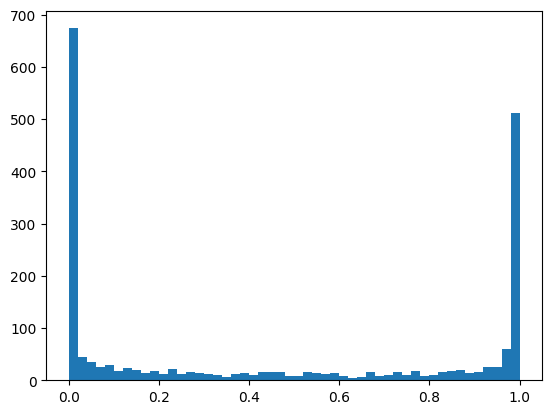

In [97]:
plt.hist(noisy_preds.mean(axis=0), bins=50)
plt.show()

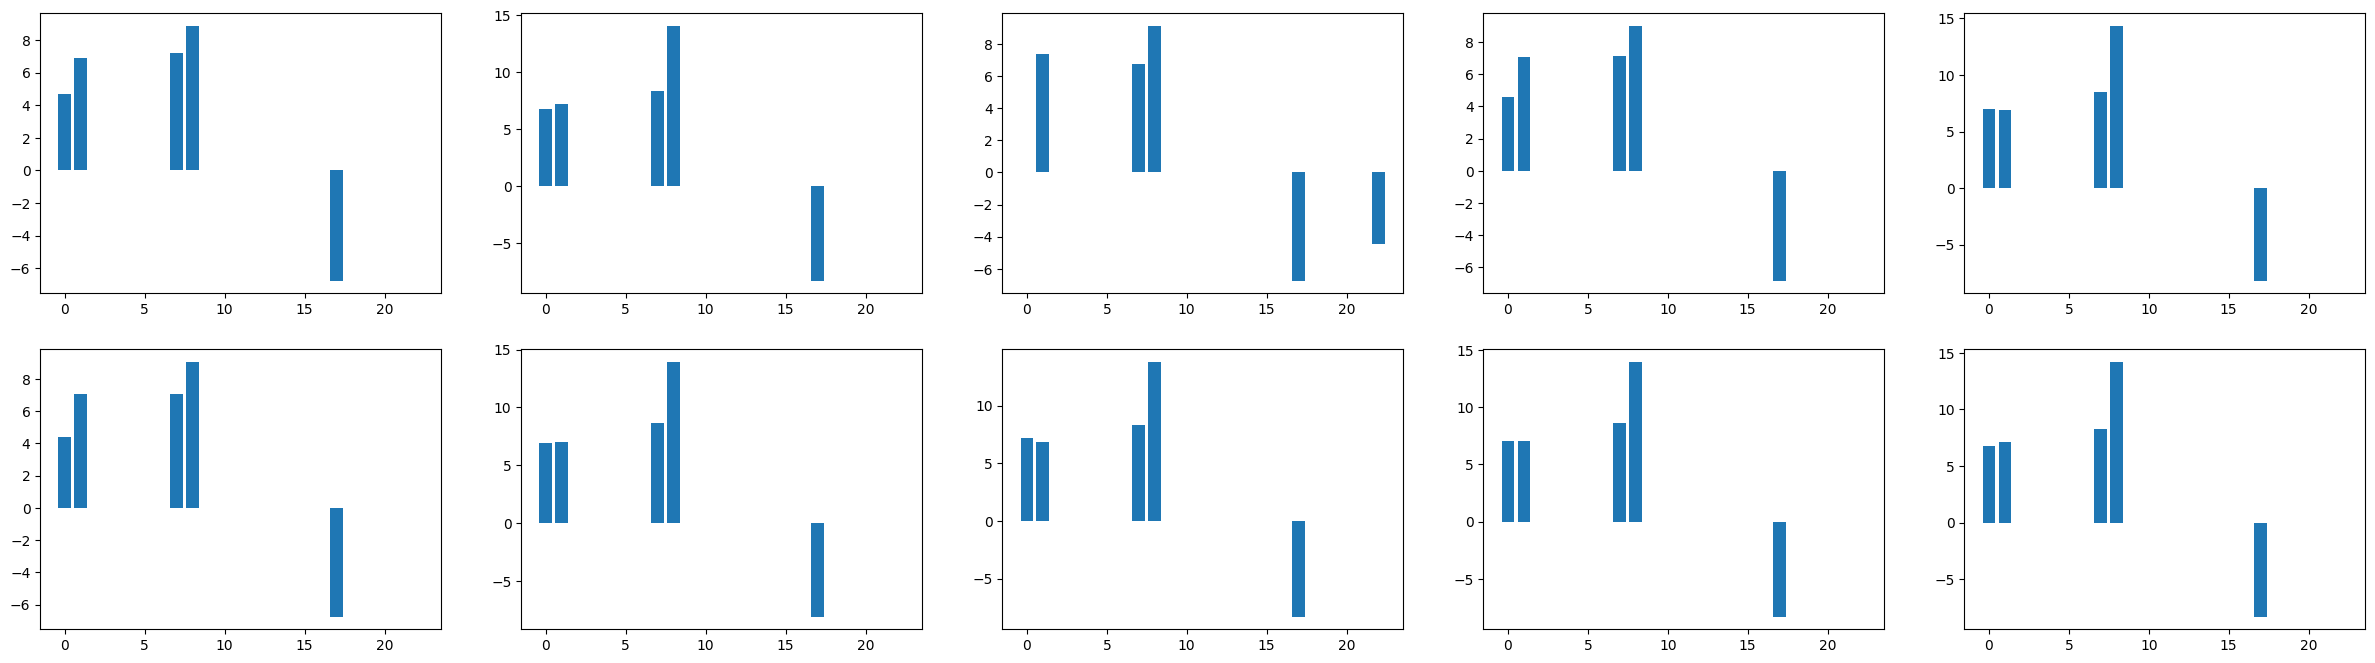

In [59]:
plot_grads(noisy_grads[:10, 2], nrows=2, ncols=5, k=5)

### Multiple Models

In [354]:
ensemble_size = 100
sigma = 0.5
n_samples = 100
model_class = get_model_class(name)
model_idx = np.random.choice(n_models, ensemble_size, replace=False)
grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in model_idx])
preds = np.array([np.load(f'{directory}/{random_source}_preds_{idx}.npy') for idx in model_idx])
model_idx

array([571, 470, 251, 365, 825, 821, 334, 630, 600, 282, 330, 156, 664,
       880, 631, 548, 897, 408, 419, 863, 508, 778, 215, 462, 956,  61,
        80, 877, 140, 164, 388, 110, 246, 917, 467, 632, 410, 869, 243,
       339, 518, 207, 184, 649, 231, 650, 112, 383,  78, 310, 737, 180,
       643, 132, 748, 793, 624,  40, 829, 125, 867, 526, 644, 808, 338,
       494, 281, 732, 183, 451, 741, 823,  91, 794, 380, 777, 752, 130,
       903, 402, 325, 363, 496, 995, 520, 381, 730, 509, 767, 151, 517,
       277, 769, 340,  68,  13, 212, 994, 368, 942])

In [355]:
noisy_grads = np.zeros((n_samples, *grads.shape))
noisy_preds = np.zeros((n_samples, *preds.shape))
layer_str = 'network.0.weight'
for j in tqdm(range(len(model_idx))):
    for i in range(n_samples):
        model = model_class(*model_args)
        state_dict = torch.load(f'{directory}/{random_source}_model_{model_idx[j]}.pth')
        # Add noise to layer weights
        state_dict[layer_str] += torch.randn(state_dict[layer_str].shape) * sigma
        model.load_state_dict(state_dict)

        # Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
        noisy_grads[i, j] = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
        noisy_preds[i, j] = model.predict(X_test, return_numpy=True)

100%|██████████| 100/100 [00:26<00:00,  3.74it/s]


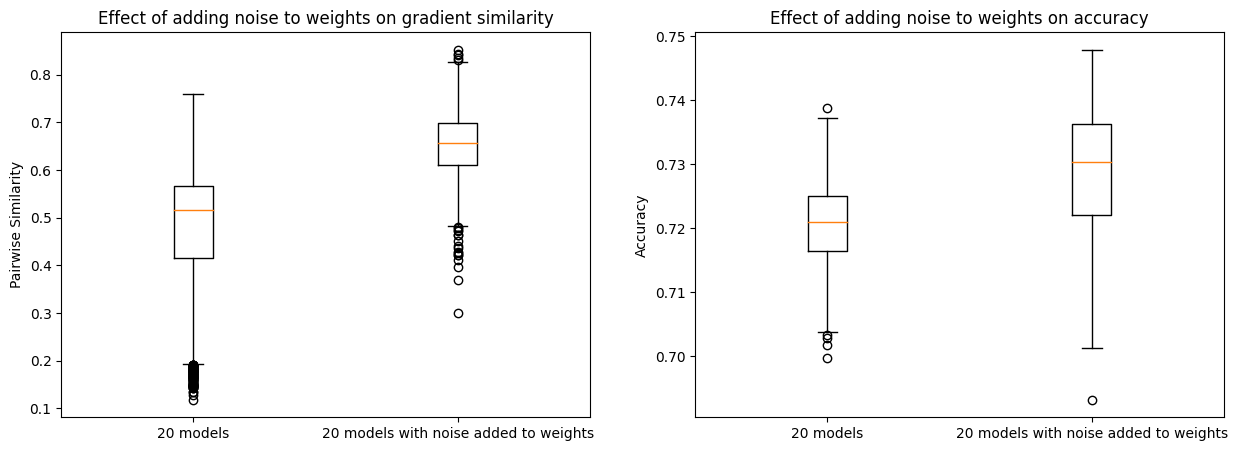

In [356]:
tk, s = get_top_k(5, grads, return_sign=True)
sa = average_pairwise_score(tk, s, top_k_sa)
tk_smooth, s_smooth = get_top_k(5, noisy_grads.mean(axis=0), return_sign=True)
sa_smooth = average_pairwise_score(tk_smooth, s_smooth, top_k_sa)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].boxplot([sa, sa_smooth], labels=['20 models', '20 models with noise added to weights'])
ax[0].set_title('Effect of adding noise to weights on gradient similarity')
ax[0].set_ylabel('Pairwise Similarity')

smooth_preds = np.where(noisy_preds.mean(axis=0) > 0.5, 1, 0)
smooth_acc = (smooth_preds==y_test).mean(axis=1)
orig_acc = (preds==y_test).mean(axis=1)
ax[1].boxplot([orig_acc, smooth_acc], labels=['20 models', '20 models with noise added to weights'])
ax[1].set_title('Effect of adding noise to weights on accuracy')
ax[1].set_ylabel('Accuracy')

plt.show()

In [353]:
ensemble_preds = np.where(preds.mean(axis=0) > 0.5, 1, 0)
smooth_ensemble_preds = np.where(smooth_preds.mean(axis=0) > 0.5, 1, 0)
(ensemble_preds==y_test).mean(), (smooth_ensemble_preds==y_test).mean()

(0.7296202531645569, 0.7326582278481013)

### Comparison to 1000 average

In [360]:
grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in range(1000)])

In [390]:
tk_all, s_all = get_top_k(5, grads, return_sign=True)
tk_all.shape

(1000, 1975, 5)

In [381]:
vote = np.zeros(grads.shape[1:])
vote.shape

(1975, 23)

In [391]:
for i in range(tk_all.shape[0]):
    for j in range(tk_all.shape[1]):
        vote[j, tk_all[i, j]] += s_all[i, j]

In [394]:
tk_vote, s_vote = get_top_k(5, vote, return_sign=True)
tk_vote*s_vote

array([[  0,   3,  14,   4, -17],
       [  7,   3, -21,  14,   0],
       [  7,  14,   0,   3,   8],
       ...,
       [  0,  14,   7,   3, -21],
       [ 14,   4,   3,   7, -19],
       [  3,   0,   1,  14, -17]])

In [397]:
grads.mean(axis=0).shape

(1975, 23)

In [402]:
tk_mean_all, s_mean_all = get_top_k(5, grads.mean(axis=0), return_sign=True)
tk_mean_all*s_mean_all

array([[  4,   3,  14,   0,  10],
       [  7, -21, -17,  14,   3],
       [  7,   0,   8, -15,   1],
       ...,
       [  0,  14,   7, -21,   3],
       [ 14,   4,   3,   7, -19],
       [  3,   0,   1,  14, -17]])

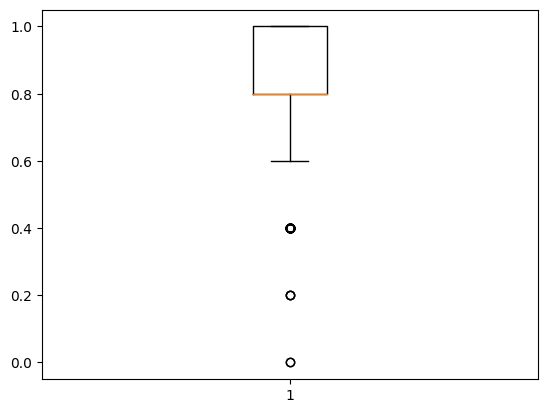

In [401]:
plt.boxplot(top_k_sa(tk_mean_all, tk_vote, s_mean_all, s_vote))
plt.show()